In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Logistic Regression

In [2]:
class LogisticRegression:
    def __init__(self, lr=0.1, epochs=1000):
        # store hyperparameters
        self.lr = lr
        self.epochs = epochs
    
    def fit(self, X, y):

        n, d = X.shape

        #init w and b
        self.w = np.zeros(d)
        self.b = 0

        # training loop
        self.X = X
        self.Y = y
        self.L=[]


        for epoch in range(self.epochs):
    
            #find z for each x_train val
            z = self.X @ self.w + self.b 
            
            #find sigmoid prop
            y_pred = self.sigmoid(z) 
            
            #find loss
            self.L.append(self.logLoss(self.Y, y_pred))
        
            #gradients
            dl_dw = (self.X.T@(y_pred-self.Y))/n
            
            dl_db = np.sum((y_pred-self.Y))/n
        
            #update
            self.w = self.w - self.lr*dl_dw
            
            self.b = self.b - self.lr*dl_db
    
    def predict_proba(self, X):
        # return probabilities
        return (self.sigmoid(X @ self.w + self.b))
        
    
    def predict(self, X):
        # return 0/1 predictions
        return (self.predict_proba(X)>=0.5).astype(int)
    
    def score(self, X, y):
        # return accuracy
        return np.mean(self.predict(X) == y)

    def loss(self):
        # return accuracy
        try:
            return self.L
        except AttributeError:
            print("Model not trained")
    
    #sigmoid
    def sigmoid(self,z):
        return 1/(1+np.exp(-z))
    
    #logLoss
    def logLoss(self,y_train, y_pred):
        y_pred = np.clip(y_pred, 1e-15, 1-1e-15)
        return -np.sum(y_train*np.log(y_pred) + (1-y_train)*np.log(1-y_pred)) / y_train.shape[0]

## K-Nearest Neighbours

In [3]:
class KNN:
    def __init__(self, k=3):
        self.k=k
    
    def fit(self, X, y):
        self.X = X
        self.y = y
    
    def _compute_distances(self, X):
        A = np.sum(X**2, axis=1, keepdims=True)
        B = np.sum(self.X**2, axis=1, keepdims=True)
        cross = np.dot(X,self.X.T)
        return np.sqrt(A + B.T - 2*cross)
        
    def predict(self, X):
        d = self._compute_distances(X)
        y_pred=[]
        for d_i in d:
            idx = np.argsort(d_i)[:self.k]
            nearest_y= self.y[idx]
            y_pred.append(np.bincount(nearest_y).argmax())
        return y_pred
    
    def score(self, X, y):
        return np.mean(self.predict(X) == y)

## Decision Trees

In [4]:
class DecisionTree:
    def __init__(self, max_depth=5):
        self.max_depth = max_depth

    def _gini(self, y):
        _, counts = np.unique(y, return_counts=True)
        p = counts / len(y)
        return 1 - np.sum(p**2)
    
    
    def _best_split(self,X,y):
        best_gini = 1
        best_feature = 0
        best_threshold = 0
    
        n,d=X.shape
    
        for feature in range(d):
            X_feature = X[:,feature]
            for thresh in np.unique(X_feature):
                left = y[X_feature<thresh]
                right = y[X_feature>=thresh]
    
                gini_left = self._gini(left)
                gini_right = self._gini(right)
    
                gini = (len(left)*gini_left + len(right)*gini_right)/n
    
                if gini<best_gini:
                    best_gini = gini
                    best_feature = feature
                    best_threshold =  thresh
                    
        return best_feature,best_threshold
    
    
    def _build_tree(self, X, y, depth):
        if depth==0 or self._gini(y) == 0:
            return np.bincount(y).argmax()
        best_feature,best_threshold = self._best_split(X,y)
        
        left_mask = X[:,best_feature]<best_threshold
        right_mask = ~left_mask

        if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
            return np.bincount(y).argmax()
    
        left_X = X[left_mask,:]
        left_y = y[left_mask]
    
        right_X = X[right_mask,:]
        right_y = y[right_mask]
    
        return {'feature':best_feature,
                'threshold':best_threshold,
                'left': self._build_tree(left_X, left_y, depth-1),
                'right':self._build_tree(right_X, right_y, depth-1)}

    def fit(self,X,y):
        self.tree = self._build_tree(X,y,self.max_depth)

    def _predict_one(self,x,node):
        if x[node['feature']]<node['threshold']:
            if type(node['left']) == dict:
                return self._predict_one(x,node['left'])
            else: 
                return node['left']
        else:
            if type(node['right']) == dict:
                return self._predict_one(x,node['right'])
            else: 
                return node['right']
            
    def predict(self,X):
        y_pred=[]
        for row in X:
            y_pred.append(self._predict_one(row,self.tree))
        return y_pred

    def score(self,X,y):
        return np.mean(self.predict(X)==y)
        

## Neural Net

In [5]:
class NeuralNet():
    '''
    -Input layer -> Hidden layer (RELU) -> 1 Output layer (sigmoid)

    -Binary cross-entropy loss
    
    -Backprop + gradient descent
    '''
    def __init__(self,lr=0.1,neurons=8, epochs = 100):
        self.lr = lr
        self.hidden_neurons = neurons
        self.epochs = epochs
        
    def sigmoid(self,z):
        return 1/(1+np.exp(-z))

    def forward(self,X):
        z1 = X @ self.W1 + self.b1
        a1 = z1.copy()
        a1[a1 < 0] = 0  # ReLU
        
        z2 = a1 @ self.W2 + self.b2
        a2 = self.sigmoid(z2)
        
        return z1, a1, z2, a2
    
    def backward (self,z1,a1,z2,a2):
        # Output layer
        dz2 = a2 - self.y_train
        dW2 = a1.T @ dz2 / len(self.y_train)
        db2 = np.sum(dz2, axis=0) / len(self.y_train)
        
        # Hidden layer
        da1 = dz2 @ self.W2.T
        dz1 = da1 * (z1 > 0)
        dW1 = self.X_train.T @ dz1 / len(self.y_train)
        db1 = np.sum(dz1, axis=0) / len(self.y_train)
    
        return dz2,dW2, db2, da1, dz1, dW1, db1
    
    def fit(self,X,y):
        n,d=X.shape
        self.X_train = X
        self.y_train = y.reshape(-1, 1)
        self.W1 = np.random.randn(d, self.hidden_neurons)*0.01
        self.b1 = np.random.randn(self.hidden_neurons,)*0.01
        self.W2 = np.random.randn(self.hidden_neurons,1)*0.01
        self.b2 = np.random.randn(1,)*0.01

        self.losses = []
  

        for _ in range(self.epochs):
            z1,a1,z2,a2 = self.forward(self.X_train)
            # Track loss
            loss = -np.mean(self.y_train * np.log(a2 + 1e-15) + (1 - self.y_train) * np.log(1 - a2 + 1e-15))
            self.losses.append(loss)
            dz2,dW2, db2, da1, dz1, dW1, db1 = self.backward(z1,a1,z2,a2)
            #update weights and biases
            self.W1 = self.W1 - self.lr*dW1
            self.W2 = self.W2 - self.lr*dW2
            self.b1 = self.b1 - self.lr*db1
            self.b2 = self.b2 - self.lr*db2
        
    
    def predict_proba(self,X):
        _,_,_,out = self.forward(X)
        return out

    def predict(self, X):
        # return 0/1 predictions
        return (self.predict_proba(X)>=0.5).astype(int)

    def score(self,X,y):
        return np.mean(self.predict(X).flatten() == y)

## Naive Bayes

In [6]:
class NaiveBayes():
    
    def fit(self,X,y):
        n,d = X.shape
        self.classes, counts = np.unique(y,return_counts=True)
        self.priors = counts/n
        self.means = []
        self.standard_devs = []
        
        for c in self.classes:
            data = X[np.where(y==c)]
            self.means.append(np.mean(data,axis=0))
            self.standard_devs.append(np.std(data,axis=0, ddof=1))

        self.means = np.array(self.means)           
        self.standard_devs = np.array(self.standard_devs)  


    def _gaussian(self,xi,x_bar,x_std):
        a = 1/(x_std * np.sqrt(2*np.pi))
        b_num = (xi - x_bar)**2
        b_den = (2*x_std**2)
        b = np.exp(-b_num/b_den)
        return np.log(a*b)

    def _predict_one(self,row):
        scores=[]
        for i in range(len(self.classes)):
            mean_c = self.means[i]
            std_c = self.standard_devs[i]
            log_p = 0
            for (xi,x_bar,x_std) in zip(row,mean_c,std_c):
                log_p+=self._gaussian(xi,x_bar,x_std)
            
            scores.append(np.log(self.priors[i])+log_p)
            
        return np.array(scores).argmax()   

    def predict(self,X):
        out = []
        for row in X:
            out.append(self._predict_one(row))
        return np.array(out)

    def score(self,X,y):
        return np.mean(self.predict(X).flatten() == y)

# TESTING

In [7]:
np.random.seed(42)
X_class0 = np.random.randn(100, 2) + np.array([0, 0])
X_class1 = np.random.randn(100, 2) + np.array([1.5, 1.5])  # closer now

X = np.vstack([X_class0, X_class1])
y = np.array([0]*100 + [1]*100)

idx = np.random.permutation(200)
X, y = X[idx], y[idx]

X_train, X_test = X[:160], X[160:]
y_train, y_test = y[:160], y[160:]


# Create grid for visualizing decision boundaries
def grid_test(model):
    xx, yy = np.meshgrid(np.linspace(-3, 5, 200), np.linspace(-3, 5, 200))
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    
    Z = np.array(model.predict(grid)).reshape(xx.shape)
    
    # Plot
    plt.contourf(xx, yy, Z, levels=[0, 0.5,3], alpha=0.3)
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, edgecolor='k')
    plt.title(f'accuracy={model.score(X_test, y_test):.2f}')
    plt.show()

#### Logistic Regression

In [8]:
model = LogisticRegression(lr=0.1, epochs=1000)
model.fit(X_train, y_train)
print(model.score(X_test, y_test))

0.875


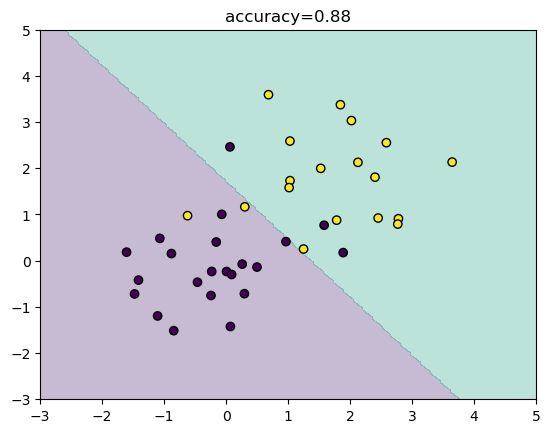

In [9]:
grid_test(model)

#### KNN

In [10]:
model = KNN(k=11)
model.fit(X_train, y_train)
print(model.score(X_test, y_test))

0.85


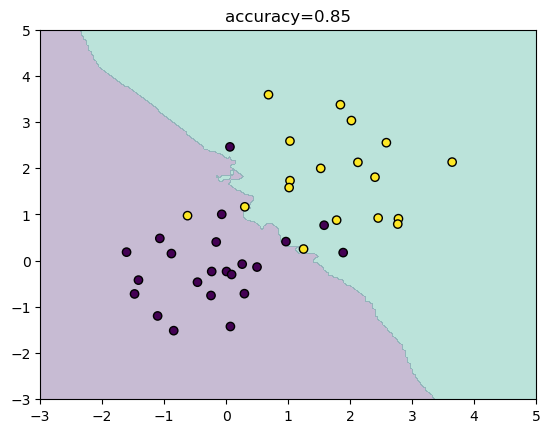

In [11]:
grid_test(model)

### Decision Tree

In [12]:
model = DecisionTree(max_depth=5)
model.fit(X_train, y_train)
print(model.score(X_test, y_test))

0.85


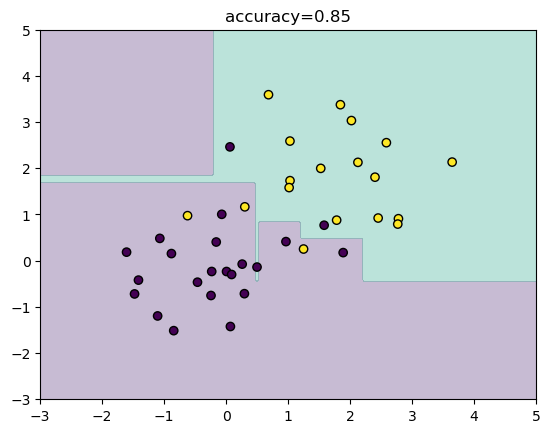

In [13]:
grid_test(model)

### Neural Net

In [14]:
model = NeuralNet(lr=0.1, neurons=9, epochs=1000)
model.fit(X_train, y_train)
print(model.score(X_test, y_test))

0.875


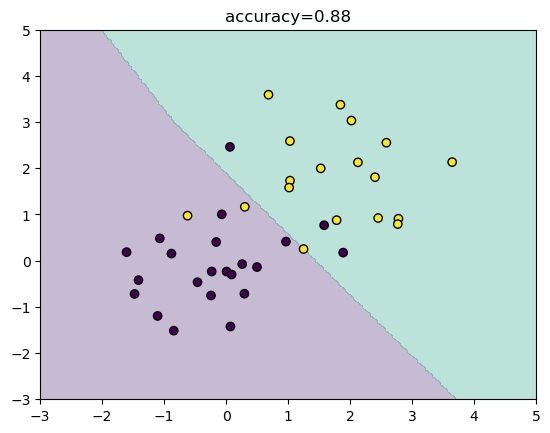

In [15]:
grid_test(model)

### Naive Bayes

In [16]:
model = NaiveBayes()
model.fit(X_train, y_train)
print(model.score(X_test, y_test))

0.875


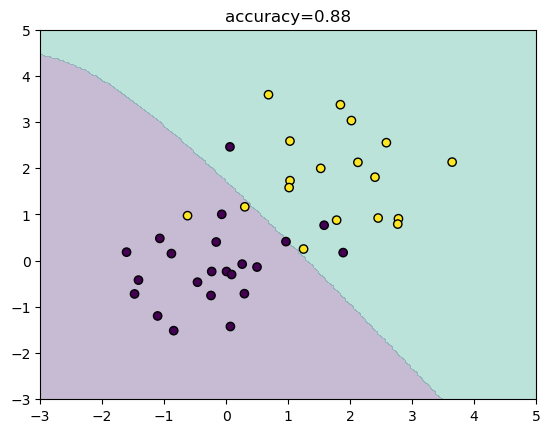

In [17]:
grid_test(model)